In [443]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency

# Importing from cleaned data notebook

In [444]:
data = pd.read_csv('data_clean.csv')

In [445]:
data.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


*Checking Shape and Value Counts*

In [446]:
data.shape

(18000, 16)

In [447]:
data["offer_accepted"].value_counts()

No     16977
Yes     1023
Name: offer_accepted, dtype: int64

# Splitting numericals and categoricals

In [448]:
cat_columns = []
num_columns = []

for i in data.columns:
    if len(data[i].unique()) > 10:
        num_columns.append(i)
    else:
        cat_columns.append(i)

In [449]:
num = data[num_columns]
num.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,1160.75,1669.0,877.0,1095.0,1002.0
1,147.25,39.0,106.0,78.0,366.0
2,276.50,367.0,352.0,145.0,242.0
3,1219.00,1578.0,1760.0,1119.0,419.0
4,1211.00,2140.0,1357.0,982.0,365.0


In [450]:
cat = data[cat_columns]
cat.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes


# Exploration on Numericals

In [451]:
for i in num.columns:
    print(num[i].describe())

count    18000.000000
mean       940.604208
std        350.072621
min         48.250000
25%        787.937500
50%       1007.000000
75%       1152.562500
max       3366.250000
Name: average_balance, dtype: float64
count    18000.000000
mean       910.266056
std        619.684111
min          0.000000
25%        393.000000
50%        772.000000
75%       1520.250000
max       3450.000000
Name: q1_balance, dtype: float64
count    18000.000000
mean       999.435667
std        457.098763
min          0.000000
25%        664.000000
50%       1032.000000
75%       1342.000000
max       3421.000000
Name: q2_balance, dtype: float64
count    18000.000000
mean      1041.904889
std        553.094705
min          0.000000
25%        633.000000
50%        945.500000
75%       1462.000000
max       3823.000000
Name: q3_balance, dtype: float64
count    18000.000000
mean       810.042889
std        558.642246
min          0.000000
25%        363.750000
50%        703.000000
75%       1211.000000
max  

*Looking at the values of the quarterly qverages, we can notice the numbers tend to be similar. The next step is to check Multicollinearity and VIF.*

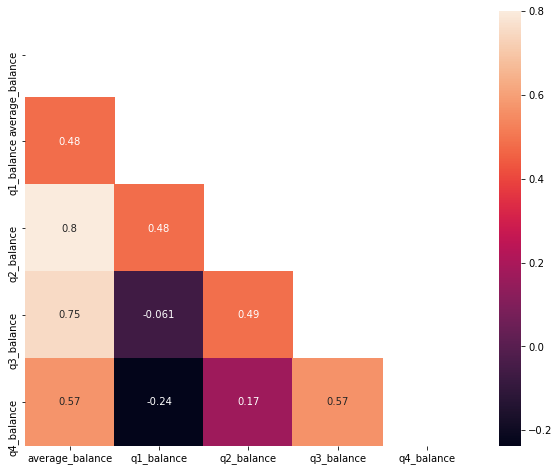

In [452]:
correlations_matrix = num.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

*Multicollinearity shows generally values above 0.50. VIF is useful to check the relation between the quarterly values and all other columns.*

In [453]:
vif = {}
numer_vif = num
numer_vif= add_constant(num)

In [454]:
for i in np.arange(numer_vif.shape[1]):
    column_name = numer_vif.columns[i]
    value = variance_inflation_factor(np.array(numer_vif), i)
    vif[column_name] = value
vif  

{'const': 8.268845743264174,
 'average_balance': 4447.523660455172,
 'q1_balance': 871.3913136229564,
 'q2_balance': 476.80592208638893,
 'q3_balance': 695.2171601202452,
 'q4_balance': 709.0042955328568}

# Feature Engineering for Numericals

*VIF shows high correlation for the Q-averages, so useful information from these columns can be assembled in an alternative way.* 
<br>

*max_quarter/min_quarter are the quarters with the highest and lowest balances*
<br>
*max/min are the highest and lowest balances*
<br>
*range is the difference between max and min balances and showing the variability of balance during the year*

In [455]:
#defining function for minmax
def minmax_func(df):
    max_q = df.idxmax(axis=1)
    min_q = df.idxmin(axis=1)
    max_ = df.max(axis=1)
    min_ = df.min(axis=1)
    range_ = (df.max(axis=1))-(df.min(axis=1))
    
    
    df["max_quarter"] = max_q
    df["min_quarter"] = min_q
    df["range"] = range_
    df["max"] = max_
    df["min"] = min_
    
    return df
   
num = minmax_func(num)

In [456]:
#renaming the columns with the quarters
num['max_quarter'] = list(map(lambda x: x[:2],num['max_quarter']))
num['min_quarter'] = list(map(lambda x: x[:2],num['min_quarter']))

In [457]:
#add new min_quarter/max_quarter columns to the categorical data and drop from numerical
cat = data[cat_columns]
cat["max_quarter"] = num["max_quarter"]
cat["min_quarter"] = num["min_quarter"]
num = num.drop(["max_quarter", "min_quarter"], axis = 1)

In [458]:
num.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,range,max,min
0,1160.75,1669.0,877.0,1095.0,1002.0,792.0,1669.0,877.0
1,147.25,39.0,106.0,78.0,366.0,327.0,366.0,39.0
2,276.50,367.0,352.0,145.0,242.0,222.0,367.0,145.0
3,1219.00,1578.0,1760.0,1119.0,419.0,1341.0,1760.0,419.0
4,1211.00,2140.0,1357.0,982.0,365.0,1775.0,2140.0,365.0


*Checking Multicollinearity with new features*

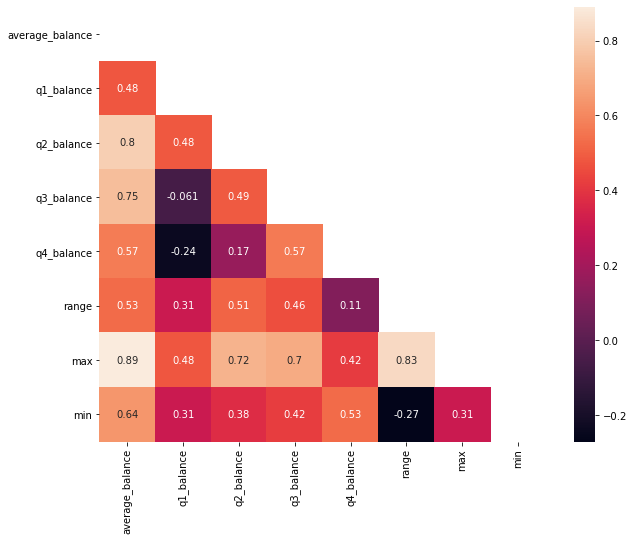

In [459]:
correlations_matrix = num.corr()
mask = np.zeros_like(correlations_matrix) 
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

In [460]:
# "max" correlates strongly with avg balance and range so remove
# q1,q2,q4 do not appear as relevant in the modeling process, so we remove
num = num.drop(["max", "q1_balance", "q2_balance","q4_balance"], axis = 1)

In [461]:
#Concatenate num + cat

In [462]:
data = pd.concat([cat, num], axis =1)

*Correlation between numerical variables and target*

In [463]:
df_num = num

In [464]:
df_num['offer_accepted'] = data['offer_accepted']

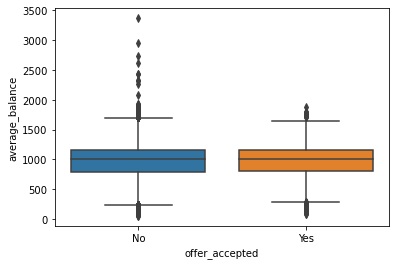

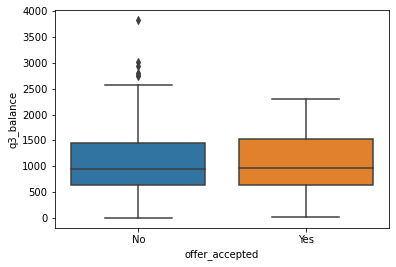

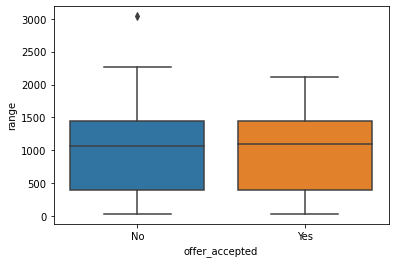

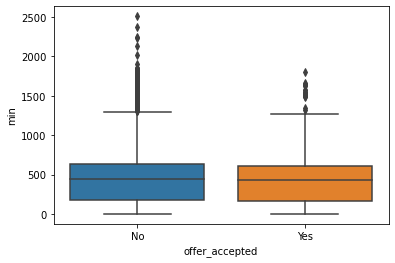

In [465]:
for i in df_num:
    if i != 'offer_accepted':
        sns.boxplot(x="offer_accepted", y=i, data = df_num)
        plt.show()
    else:
        continue
#result: keep q3_balance

# Exploration on Categoricals

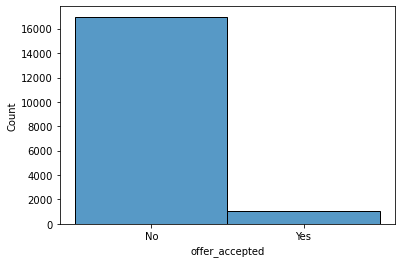

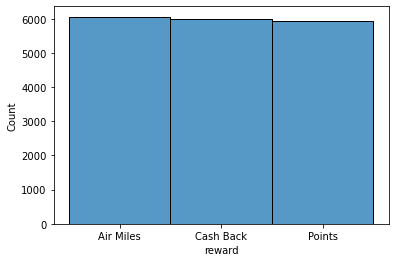

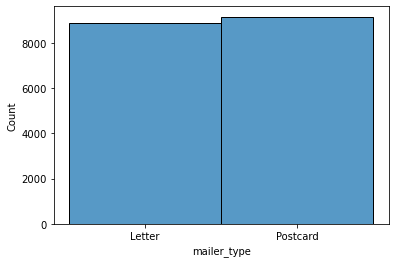

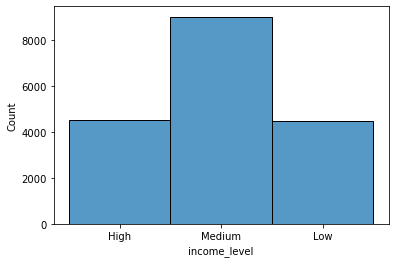

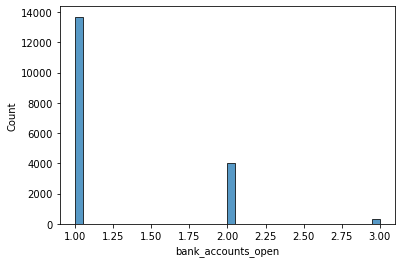

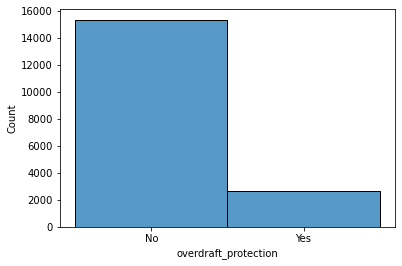

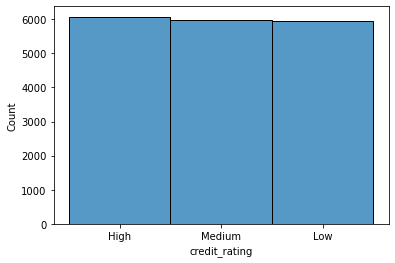

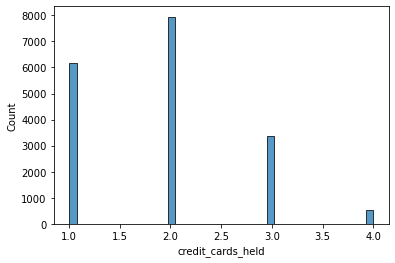

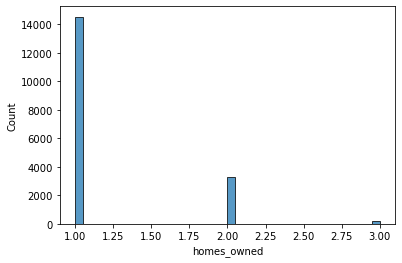

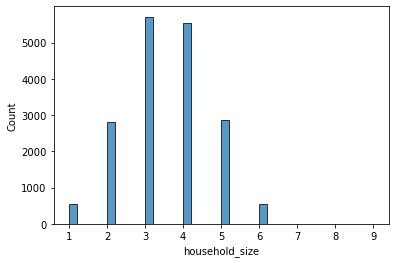

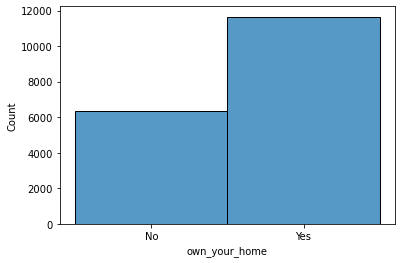

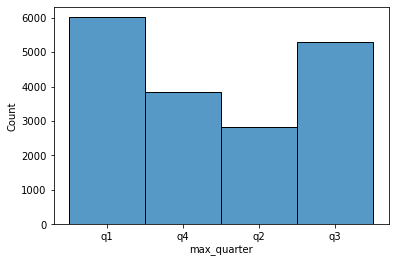

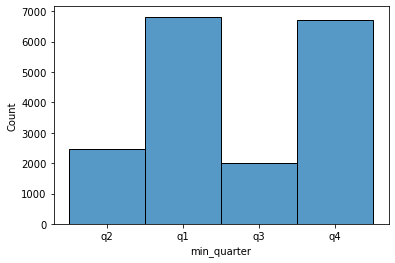

In [466]:
for i in range(cat.shape[1]):
    sns.histplot(cat[cat.columns[i]], bins=40)
    plt.show()

*Checking other columns with multiple values to decide whether to group or keep all categories.*

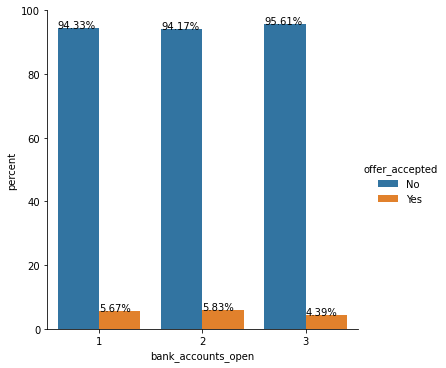

In [467]:
df = data
x,y = 'bank_accounts_open', 'offer_accepted'
df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
g = sns.catplot(x=x,y='percent',hue=y, kind='bar',data=df1)
g.ax.set_ylim(0,100)
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

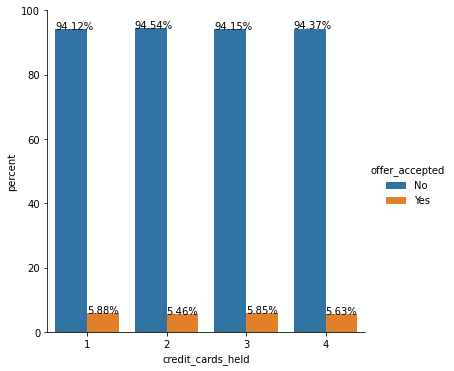

In [468]:
df = data
x,y = 'credit_cards_held', 'offer_accepted'
df1 = df.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
g = sns.catplot(x=x,y='percent',hue=y, kind='bar',data=df1)
g.ax.set_ylim(0,100)
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

*Replacing low frequency values in household_size and clustering them*

In [469]:
data['household_size'] = data['household_size'].apply(lambda x: 6 if x>6 else x)

In [470]:
#create new dataframe dropping the target variable
cat2 = cat.drop(['offer_accepted'], axis = 1)
cat2.shape

(18000, 12)

*Check chi-squared value of all pairs of categorical variables*

In [471]:
def chi2_check (data):
    lst1 = []
    lst2 = []
    lst3 = []
    for i,n in enumerate(data.columns):
        x = 1
        while x < len(data.columns)-i: 
            crosstab = pd.crosstab(data[n],data[data.columns[i+x]])
            lst1.append(n)
            lst2.append(data.columns[i+x])
            lst3.append(chi2_contingency(crosstab, correction=False)[1])
            x += 1
    df = pd.concat([pd.DataFrame(lst1),pd.DataFrame(lst2),pd.DataFrame(lst3)], axis =1)
    return df
df = chi2_check (cat2)

In [472]:
#check which pairs of columns have a p value < 0.05, which means a high correlation
df[df.iloc[:,2]<0.05]

,0,0,0
19,mailer_type,max_quarter,0.007761
49,credit_rating,max_quarter,0.008498
50,credit_rating,min_quarter,0.013072
54,credit_cards_held,max_quarter,0.009283
65,max_quarter,min_quarter,0.000000


In [473]:
#drop "max_quarter" and "min_quarter" from main cat dataset as they are correlated with each other and other categorical variables
cat = cat.drop(["max_quarter", "min_quarter"], axis=1)
cat.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes


*Check Chi Square between categorical variables and target to check for correlation*

In [474]:
#check chi-squared values of all pairs of categorical variables and target
df = chi2_check (cat)

In [475]:
df[(df.iloc[:,0]=='offer_accepted')&(df.iloc[:,2]>0.05)]

,0,0,0
3,offer_accepted,bank_accounts_open,0.578715
4,offer_accepted,overdraft_protection,0.704005
6,offer_accepted,credit_cards_held,0.719141
7,offer_accepted,homes_owned,0.881636
9,offer_accepted,own_your_home,0.967346


In [476]:
#checking for variable in relation to target
df.head(10)

,0,0,0
0,offer_accepted,reward,7.103827e-23
1,offer_accepted,mailer_type,4.191441e-39
2,offer_accepted,income_level,1.463496e-25
3,offer_accepted,bank_accounts_open,5.787149e-01
4,offer_accepted,overdraft_protection,7.040047e-01
5,offer_accepted,credit_rating,5.967269e-97
6,offer_accepted,credit_cards_held,7.191405e-01
7,offer_accepted,homes_owned,8.816359e-01
8,offer_accepted,household_size,4.550923e-04
9,offer_accepted,own_your_home,9.673462e-01


In [477]:
# Result: p value is high (>0.05) for the following cat variables: bank_accounts_open, overdraft_protection, credit_cards_held, homes_owned, own_your_home.
# So drop them as they are not related to the target variable
data = data.drop(["bank_accounts_open", "overdraft_protection", "credit_cards_held", "homes_owned", "own_your_home"], axis = 1)

*Plot to show the chi square relation of categorical variables to Target Variable.*

<BarContainer object of 10 artists>

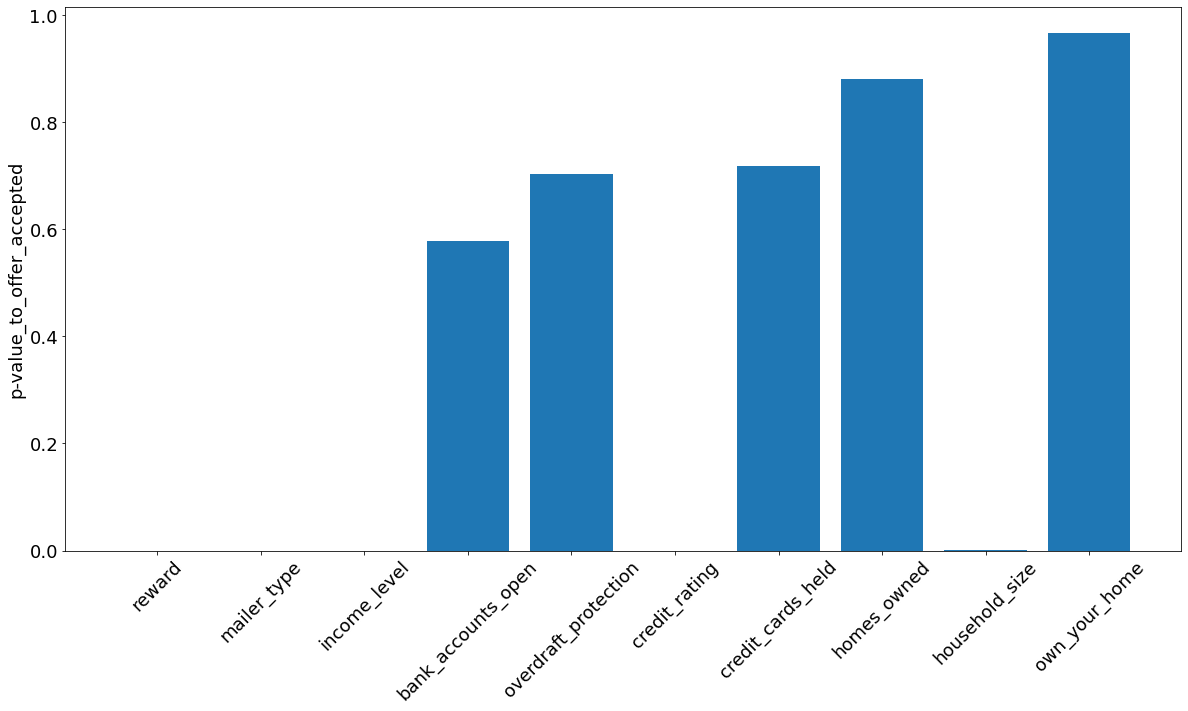

In [478]:
plt.figure(figsize=(20,10))
plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18)
plt.ylabel('p-value_to_offer_accepted', fontsize=18)
plt.bar(df.iloc[0:10,1],df.iloc[0:10,2])
#drop categories with bars

# Numericals vs Categoricals

*Check categorical variables against numericals, excluding the target.*

In [479]:
#drop target variable
cat2 = cat.drop(['offer_accepted'], axis = 1)

In [481]:
cat2.head()

,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home
0,Air Miles,Letter,High,1,No,High,2,1,4,No
1,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes
2,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes
3,Air Miles,Letter,Medium,2,No,High,1,1,4,No
4,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes


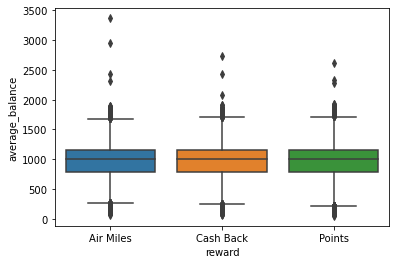

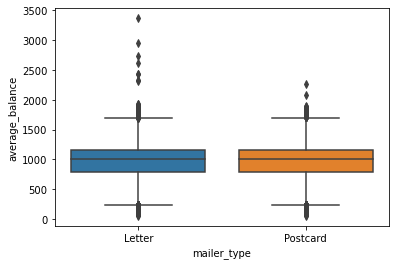

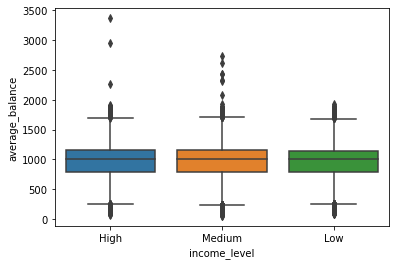

ValueError: Could not interpret input 'bank_accounts_open'

In [480]:
#Check average_balance against categorical variables(exclude target)
for i in cat2:
    sns.boxplot(x=i, y="average_balance", data = data)
    plt.show()

In [ ]:
#check min against categorical variables
for i in cat2:
    sns.boxplot(x=i, y="min", data = data)
    plt.show()

In [ ]:
#check range against categorical variables
for i in cat2:
    sns.boxplot(x=i, y="range", data = data)
    plt.show()

In [ ]:
#check q3 against categorical variables
for i in cat2:
    sns.boxplot(x=i, y="q3_balance", data = data)
    plt.show()

*Result: no multicollinearity between categorical and numerical variables was found*

# Removing Outliers

*Plo

In [ ]:
cat

In [ ]:
cat["offer_accepted"].value_counts()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5,2,figsize = (20, 20)) 
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 

sns.histplot(data["average_balance"], ax=ax1)
sns.boxplot(data['average_balance'], ax=ax2)
sns.histplot(data['q3_balance'], ax=ax3)
sns.boxplot(data['q3_balance'], ax=ax4)
sns.histplot(data['range'], ax=ax5)
sns.boxplot(data['range'], ax=ax6)
sns.histplot(data['min'], ax=ax7)
sns.boxplot(data['min'], ax=ax8)
sns.histplot(data['max'], ax=ax9)
sns.boxplot(data['max'], ax=ax10)

plt.show()

In [ ]:
#remove outliers from average balance
def remove_outliers(df, x, k):
    iqr = np.percentile(df[x],75) - np.percentile(df[x],25)
    upper_limit = np.percentile(df[x],75) + k*iqr
    lower_limit = np.percentile(df[x],25) - k*iqr
    df = df[(df[x]>lower_limit) & (df[x]<upper_limit)]
    return df

In [ ]:
#remove outliers from numericals:

data = remove_outliers (data, 'average_balance', 1.5)
data = remove_outliers (data, 'min', 1.5)
data = remove_outliers (data, 'q3_balance', 1)

#these columns are not used in the final model
#data = remove_outliers (data, 'range', 1.5)
#data = remove_outliers (data, 'max', 1.5)

In [ ]:
data.shape

In [ ]:
data["offer_accepted"].value_counts()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5,2,figsize = (20, 20)) 
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 

sns.histplot(data["average_balance"], ax=ax1)
sns.boxplot(data['average_balance'], ax=ax2)
sns.histplot(data['q3_balance'], ax=ax3)
sns.boxplot(data['q3_balance'], ax=ax4)
sns.histplot(data['range'], ax=ax5)
sns.boxplot(data['range'], ax=ax6)
sns.histplot(data['min'], ax=ax7)
sns.boxplot(data['min'], ax=ax8)
sns.histplot(data['max'], ax=ax9)
sns.boxplot(data['max'], ax=ax10)

plt.show()

Splitting numericals and categoricals again

In [ ]:
cat_columns = []
num_columns = []

for i in data.columns:
    if len(data[i].unique()) > 10:
        num_columns.append(i)
    else:
        cat_columns.append(i)   

num = data[num_columns]
cat = data[cat_columns]

Numericals - applying transformations, tested LOG transformation, BoxCox and Square Root

In [ ]:
def log_transform_clean(x):
    if x>0:
        return np.log(x)
    else:
        return 0  # in the code to be used with dataframe, we will use np.NaN here 

In [ ]:
#checking transformations of min
def transformations (data, name):

    data[name+"_sqrt"] = num[name]**(1/2)
    data[name+"_log"] = list(map(log_transform_clean, num[name]))

    if data[name].min() > 0:
        box_cox, lmbda = stats.boxcox(data[name])
        data[name+"_bc"]= box_cox

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20,15)) 
        plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
        sns.histplot(data[name], ax=ax1)
        sns.histplot(data[name+"_sqrt"], ax=ax2)
        sns.histplot(data[name+"_log"], ax=ax3)
        sns.histplot(data[name+"_bc"], ax=ax4)
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,5)) 
        plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None) 
        sns.histplot(data[name], ax=ax1)
        sns.histplot(data[name+"_sqrt"], ax=ax2)
        sns.histplot(data[name+"_log"], ax=ax3)
    return data

In [ ]:
#num = transformations(num, "range")
num = transformations(num, "q3_balance")
num = transformations(num, "min")
#num = transformations(num, "max")
num = transformations(num, "average_balance")

In [ ]:
num.head()

In [ ]:
#choose which transformations/columns to use
num = num[["min_sqrt", "q3_balance_sqrt", "average_balance"]] 

In [ ]:
num.shape

In [ ]:
num.head()

In [ ]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(num)
num_standardized = transformer.transform(num)

In [ ]:
pd.DataFrame(num_standardized).head()

In [ ]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(num)
num_normalized = transformer.transform(num)

In [ ]:
pd.DataFrame(num_normalized).head()

Categorical Encoding

In [ ]:
cat.head()

In [ ]:
cat.shape

In [ ]:
#ordinal encoding
#cat["credit_rating"]=cat["credit_rating"].apply(lambda x : 3 if x == "High" else(2 if x == "Medium" else 1))
#cat["income_level"]=cat["income_level"].apply(lambda x : 3 if x == "High" else(2 if x == "Medium" else 1))
#cat["overdraft_protection"] = cat["overdraft_protection"].apply(lambda x : 1 if x == "Yes" else 0)
#ord_cat = cat.select_dtypes(exclude = object)

In [ ]:
cat.head()

Encoding Nominal Categoricals - OneHot Encoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
y = cat["offer_accepted"]
cat = cat.drop(["offer_accepted"], axis = 1)

In [ ]:
enc = OneHotEncoder(handle_unknown='error', drop='first')
enc_cat = pd.DataFrame(enc.fit_transform(cat).toarray())


concat with Scaled Numerical

In [ ]:
data_enc = pd.DataFrame(np.concatenate([enc_cat,num_normalized], axis =1))

In [ ]:
data_enc.head()

In [ ]:
data_enc.shape

In [ ]:
# from sklearn.preprocessing import StandardScaler
# transformer = StandardScaler().fit(data_enc)
# # x_standardized = transformer.transform(data_enc)
# print(x_standardized.shape)

In [ ]:
# from sklearn.preprocessing import Normalizer
# transformer = Normalizer().fit(data_enc)
# x_normalized = transformer.transform(data_enc)
# print(x_normalized.shape)

In [ ]:
X = data_enc

Concatenate X with y and export to csv

In [ ]:
data_preprocessed = pd.DataFrame(np.concatenate([X,pd.DataFrame(y)],axis=1))

In [ ]:
data_preprocessed.to_csv('data_preprocessed.csv', index=False)